### Import modules

In [1]:
import pickle
import pandas as pd
import numpy as np
import pymysql.cursors
import sys
import matplotlib.pyplot as plt

### Connect to database and preview the dataframe

In [2]:
URI = "database-test1.ckvmcnbipeqn.eu-west-1.rds.amazonaws.com"
PORT = 3306
DB = "dbbikes"
USER = "picto"
PASSWORD = "Comp30830"
try:
    conn = pymysql.connect(host=URI, user=USER, password=PASSWORD, port=PORT, database=DB)

    cursor = conn.cursor()
    sql = "SELECT * FROM db_bikes.station_new_availability"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_bikes_availability = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_bikes_availability.tail()

Database connected successfully


,number,available_bikes,available_bike_stands,last_update
1089721,39,5,14,2023-04-15 22:55:30
1089722,83,12,28,2023-04-15 22:48:12
1089723,92,31,9,2023-04-15 22:54:38
1089724,21,25,4,2023-04-15 22:51:54
1089725,88,11,19,2023-04-15 22:51:01


### Add columns

In [3]:

df_bikes_availability['weekday'] = df_bikes_availability.last_update.dt.day_name()
df_bikes_availability.loc[df_bikes_availability.last_update >= pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour + 1
df_bikes_availability.loc[df_bikes_availability.last_update < pd.Timestamp('2023-03-26 01:00:00'), 'hour'] = df_bikes_availability.last_update.dt.hour
df_bikes_availability['total_stands'] = df_bikes_availability['available_bikes'] + df_bikes_availability['available_bike_stands']

In [4]:
df_bikes_availability.tail()

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands
1089721,39,5,14,2023-04-15 22:55:30,Saturday,23.0,19
1089722,83,12,28,2023-04-15 22:48:12,Saturday,23.0,40
1089723,92,31,9,2023-04-15 22:54:38,Saturday,23.0,40
1089724,21,25,4,2023-04-15 22:51:54,Saturday,23.0,29
1089725,88,11,19,2023-04-15 22:51:01,Saturday,23.0,30


### Check null data

In [5]:
df_bikes_availability[df_bikes_availability.isnull().values==True]

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands


### Check duplicate data

In [6]:
# df_bikes_availability.duplicated().sum()
# include_duplicate = df_bikes_availability[df_bikes_availability.duplicated(keep=False)].shape[0]
# print("There are {} duplicate rows including the first row.".format(include_duplicate))
# include_duplicate_lines = df_bikes_availability[df_bikes_availability.duplicated(keep=False)]
# print(include_duplicate_lines)

### descriptive statistics

In [7]:
# check all of the data types
print(df_bikes_availability.dtypes)

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update              datetime64[ns]
weekday                          object
hour                            float64
total_stands                      int64
dtype: object


In [8]:
# modify the data type of weekday to category
df_bikes_availability['weekday'] = df_bikes_availability['weekday'].astype('category')
df_bikes_availability.select_dtypes(['category']).describe().T

,count,unique,top,freq
weekday,1089726,7,Wednesday,163427


In [9]:
numeric_columns = df_bikes_availability.select_dtypes(['int64']).columns
df_bikes_availability[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,1089726.0,58.824561,34.115466,1.0,29.0,58.5,89.0,117.0
available_bikes,1089726.0,11.439005,9.450369,0.0,3.0,10.0,17.0,40.0
available_bike_stands,1089726.0,20.095413,10.940626,0.0,12.0,20.0,29.0,40.0
total_stands,1089726.0,31.534418,8.026097,0.0,29.0,30.0,40.0,40.0


In [10]:
df_bikes_availability.select_dtypes(['datetime64[ns]']).describe().T

,count,mean,min,25%,50%,75%,max
last_update,1089726,2023-03-30 06:23:24.596641280,2023-03-13 14:37:42,2023-03-21 22:21:59,2023-03-30 06:18:04,2023-04-07 14:20:38,2023-04-15 22:57:46


### plot

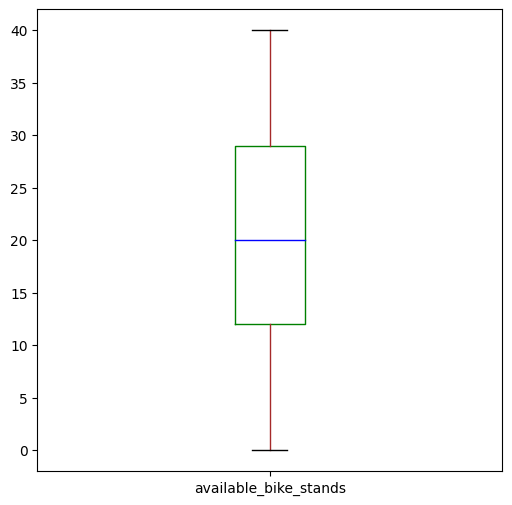

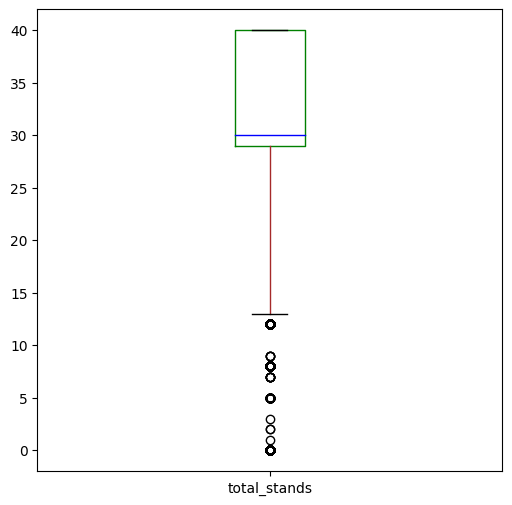

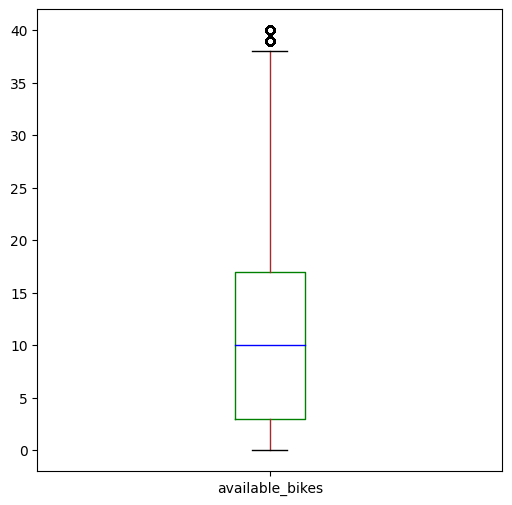

In [11]:
station_info = {'available_bikes','available_bike_stands', 'total_stands'}
color = {'boxes': 'Green', 'whiskers': 'Brown', 'medians': 'Blue', 'caps': 'Black'}

for col in station_info:
    f = df_bikes_availability[col].plot(color=color, kind='box', figsize=(6, 6))
    plt.show()

array([[<Axes: title={'center': 'available_bike_stands'}>,
        <Axes: title={'center': 'total_stands'}>],
       [<Axes: title={'center': 'available_bikes'}>, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

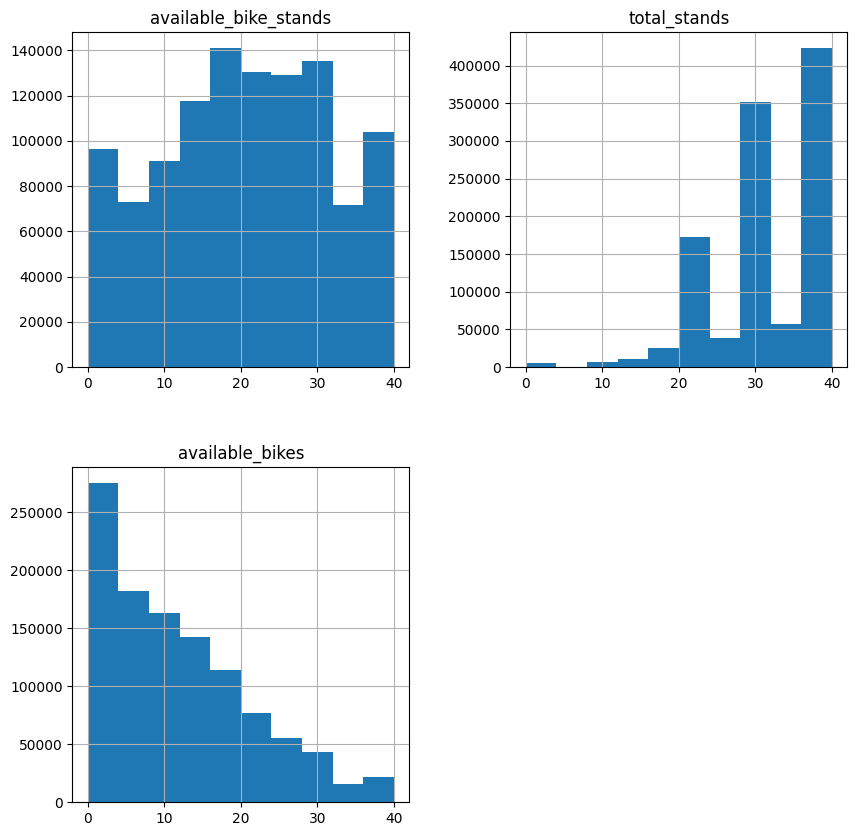

In [12]:
plt.figure()
df_bikes_availability[list(station_info)].hist(figsize=(10, 10))

<Axes: xlabel='available_bikes', ylabel='available_bike_stands'>

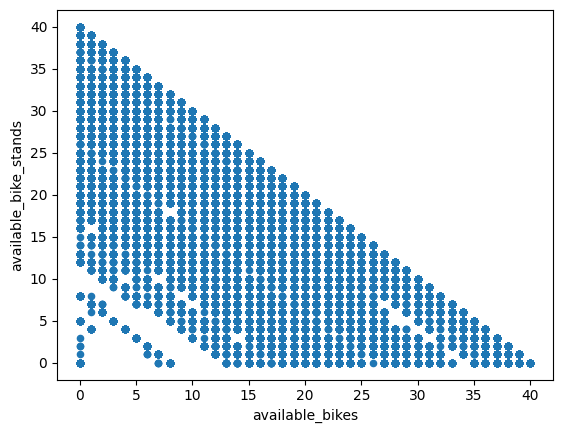

In [13]:
df_bikes_availability.plot(kind='scatter', x='available_bikes', y='available_bike_stands')

<Axes: xlabel='weekday'>

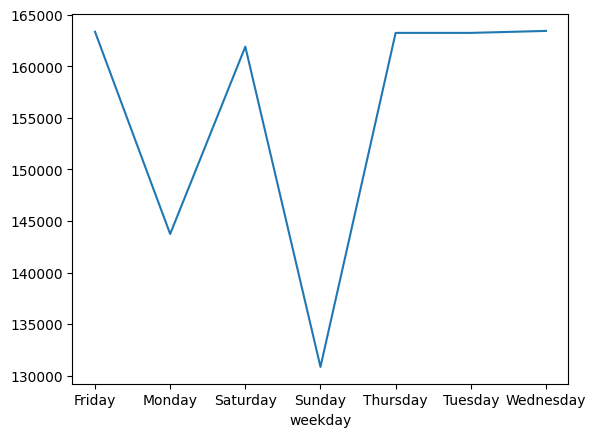

In [14]:
df_bikes_availability.weekday.value_counts().sort_index().plot()

### store the fixed station stands

In [15]:
df_station = pd.DataFrame(df_bikes_availability, columns=['number', 'total_stands'])
df_station = df_station.drop_duplicates(['number'])
df_station = df_station.reset_index().drop('index',axis=1)
df_station = df_station.sort_values(['number'], ascending=[True])
df_station

,number,total_stands
16,1,31
83,2,20
104,3,20
44,4,20
39,5,40
...,...,...
31,113,40
28,114,40
56,115,30
36,116,30


In [16]:
df_station['total_stands'][df_bikes_availability['number'] == 2].iloc[0]

20

In [17]:
station_total_stands = dict()
for ID in df_station['number']:
    station_total_stands[ID] = df_station['total_stands'][df_station['number'] == ID].iloc[0]
print(station_total_stands)

{1: 31, 2: 20, 3: 20, 4: 20, 5: 40, 6: 20, 7: 29, 8: 30, 9: 24, 10: 16, 11: 30, 12: 20, 13: 30, 14: 30, 15: 13, 16: 20, 17: 20, 18: 30, 19: 30, 20: 30, 21: 30, 22: 19, 23: 30, 24: 20, 25: 30, 26: 20, 27: 20, 28: 30, 29: 29, 30: 20, 31: 20, 32: 30, 33: 23, 34: 30, 35: 29, 36: 40, 37: 30, 38: 40, 39: 20, 40: 21, 41: 20, 42: 30, 43: 30, 44: 30, 45: 30, 47: 40, 48: 40, 49: 40, 50: 40, 51: 40, 52: 32, 53: 40, 54: 33, 55: 34, 56: 40, 57: 23, 58: 40, 59: 20, 60: 30, 61: 25, 62: 40, 63: 35, 64: 40, 65: 40, 66: 40, 67: 40, 68: 40, 69: 40, 71: 40, 72: 31, 73: 30, 74: 30, 75: 40, 76: 38, 77: 29, 78: 40, 79: 27, 80: 40, 82: 8, 83: 40, 84: 30, 85: 35, 86: 38, 87: 38, 88: 30, 89: 40, 90: 40, 91: 30, 92: 40, 93: 40, 94: 40, 95: 40, 96: 30, 97: 40, 98: 40, 99: 30, 100: 25, 101: 30, 102: 40, 103: 40, 104: 40, 105: 36, 106: 40, 107: 40, 108: 35, 109: 29, 110: 40, 111: 40, 112: 30, 113: 40, 114: 40, 115: 30, 116: 30, 117: 39}


In [18]:
# descriptive statistic of station data
df_station.describe().T

,count,mean,std,min,25%,50%,75%,max
number,114.0,58.824561,34.266071,1.0,29.25,58.5,88.75,117.0
total_stands,114.0,31.789474,7.824936,8.0,29.00,30.0,40.00,40.0


In [19]:
len(station_total_stands)

114

### save the data into csv

In [20]:
df_bikes_availability.to_csv('df_bikes_availability.csv',index=None)

In [21]:
df_station.to_csv('df_station.csv',index=None)

### weather data

In [26]:
URI = "database-test1.ckvmcnbipeqn.eu-west-1.rds.amazonaws.com"
PORT = 3306
DB = "dbbikes"
USER = "picto"
PASSWORD = "Comp30830"
try:
    conn = pymysql.connect(host=URI, user=USER, password=PASSWORD, port=PORT, database=DB)
    sql = "SELECT * FROM db_bikes.dublin_new_weather"
    cursor.execute(sql)
    results = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df_curr_weather = pd.DataFrame(results, columns= columns)
    print("Database connected successfully")
except Exception as e:
    sys.exit(e)

df_curr_weather.tail()

Database connected successfully


,dt,sunrise,sunset,temp,feels_like,pressure,humidity,uvi,clouds,visibility,wind_speed,wind_deg,weather_description,temp_min,temp_max
8796,2023-04-15 22:38:49,2023-04-15 05:26:13,2023-04-15 19:23:41,281.99,280.21,1021,87,0.0,75,9000,3.09,220,light rain,275.91,285.28
8797,2023-04-15 22:43:49,2023-04-15 05:26:13,2023-04-15 19:23:41,281.99,280.21,1021,87,0.0,75,9000,3.09,220,light rain,275.91,285.28
8798,2023-04-15 22:48:50,2023-04-15 05:26:13,2023-04-15 19:23:41,282.06,280.30,1020,87,0.0,75,9000,3.09,220,broken clouds,275.91,285.28
8799,2023-04-15 22:53:50,2023-04-15 05:26:13,2023-04-15 19:23:41,282.06,280.30,1020,87,0.0,75,9000,3.09,220,broken clouds,275.91,285.28
8800,2023-04-15 22:58:50,2023-04-15 05:26:13,2023-04-15 19:23:41,282.06,280.30,1020,87,0.0,75,9000,3.09,220,broken clouds,275.91,285.28


In [28]:
df_curr_weather = df_curr_weather[['dt','temp','clouds','wind_speed','weather_description','pressure']]

In [29]:
df_curr_weather.dtypes

dt                     datetime64[ns]
temp                          float64
clouds                          int64
wind_speed                    float64
weather_description            object
pressure                        int64
dtype: object

In [30]:
df_curr_weather['weather_description'] = df_curr_weather['weather_description'].astype('category')


/var/folders/lj/wbk2xs0517dc9q1kh9bnrhd00000gn/T/ipykernel_9051/2860788863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curr_weather['weather_description'] = df_curr_weather['weather_description'].astype('category')


In [31]:
df_curr_weather.dtypes

dt                     datetime64[ns]
temp                          float64
clouds                          int64
wind_speed                    float64
weather_description          category
pressure                        int64
dtype: object

In [32]:
df_curr_weather[df_curr_weather.isnull().values==True]


,dt,temp,clouds,wind_speed,weather_description,pressure


In [33]:
duplicate = df_curr_weather[df_curr_weather.duplicated(keep=False)].shape[0]
print("There are {} duplicate rows including the first row.".format(duplicate))

There are 0 duplicate rows including the first row.


In [34]:
df_curr_weather.to_csv('df_curr_weather.csv', index=None)

#### Merge availability and weather dataframe

In [35]:
df_bikes_availability_sorted = df_bikes_availability.sort_values(by=['last_update'])
df_curr_weather_sorted = df_curr_weather.sort_values(by=['dt'])
df_merged = pd.merge_asof(df_bikes_availability_sorted,df_curr_weather_sorted,left_on='last_update',right_on='dt')
df_merged.tail()

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands,dt,temp,clouds,wind_speed,weather_description,pressure
1089721,85,4,31,2023-04-15 22:57:20,Saturday,23.0,35,2023-04-15 22:53:50,282.06,75.0,3.09,broken clouds,1020.0
1089722,14,25,5,2023-04-15 22:57:30,Saturday,23.0,30,2023-04-15 22:53:50,282.06,75.0,3.09,broken clouds,1020.0
1089723,79,1,26,2023-04-15 22:57:43,Saturday,23.0,27,2023-04-15 22:53:50,282.06,75.0,3.09,broken clouds,1020.0
1089724,48,3,37,2023-04-15 22:57:46,Saturday,23.0,40,2023-04-15 22:53:50,282.06,75.0,3.09,broken clouds,1020.0
1089725,56,6,34,2023-04-15 22:57:46,Saturday,23.0,40,2023-04-15 22:53:50,282.06,75.0,3.09,broken clouds,1020.0


In [36]:
df_merged[df_merged.isnull().values==True]

,number,available_bikes,available_bike_stands,last_update,weekday,hour,total_stands,dt,temp,clouds,wind_speed,weather_description,pressure
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN
0,8,4,26,2023-03-13 14:37:42,Monday,14.0,30,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN
1203,88,12,18,2023-03-13 15:17:59,Monday,15.0,30,NaT,NaN,NaN,NaN,NaN,NaN


In [37]:
df_merged.dropna(axis=0,how='any',inplace=True)

In [38]:
df_merged = df_merged.drop(columns=['total_stands'])

In [39]:
df_merged.dtypes

number                            int64
available_bikes                   int64
available_bike_stands             int64
last_update              datetime64[ns]
weekday                        category
hour                            float64
dt                       datetime64[ns]
temp                            float64
clouds                          float64
wind_speed                      float64
weather_description            category
pressure                        float64
dtype: object

In [40]:
df_merged.to_csv('df_merged.csv',index=True)